In [1]:
import numpy as np
import json
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.ticker import MaxNLocator

import xobjects as xo
import xtrack as xt
import xpart as xp

import pymadx
from xcoll_plotting import plot_functions as xcp

No pytransport functionality
No pytransport functionality


In [2]:
# FUNCTION TO FIND BAD APERTURES IN LINE THAT PREVENT CLOSED ORBIT SEARCH

def find_axis_intercepts(x_coords, y_coords):
    x_intercepts = []
    y_intercepts = []

    for i in range(len(x_coords)):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % len(x_coords)], y_coords[(i + 1) % len(y_coords)]

        if x1 == x2:
        # Vertical line, no y-intercept
            y_intercept = 0.0 if x1 == x2 == 0.0 else None
        else:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - (slope * x1)

        if y1 == y2:
        # Horizontal line, no x-intercept
            x_intercept = 0.0 if y1 == y2 == 0.0 else None
        else:
            slope = (x2 - x1) / (y2 - y1)
            x_intercept = x1 - (slope * y1)

        # Check if the x-intercept is within the range of x1 and x2
        if x_intercept is not None and (x1 <= x_intercept <= x2 or x2 <= x_intercept <= x1):
            x_intercepts.append(x_intercept)

        # Check if the y-intercept is within the range of y1 and y2
        if y_intercept is not None and (y1 <= y_intercept <= y2 or y2 <= y_intercept <= y1):
            y_intercepts.append(y_intercept)

    return x_intercepts, y_intercepts



def find_bad_offset_apertures(line):
    aperture_offsets = {}
    for name, element in line.element_dict.items():
        if 'offset' in name and element.__class__.__name__.startswith('XYShift'):
            aper_name = name.split('_offset')[0]
            aperture_offsets[aper_name] = (element.dx, element.dy)

    bad_apers = {}
    for ap_name, offset in aperture_offsets.items():
        aperture_el = line.element_dict[ap_name]

        cname= aperture_el.__class__.__name__
        ap_dict = aperture_el.to_dict()

        if cname == 'LimitEllipse':
            x_min = -ap_dict['a']
            x_max = ap_dict['a']
            y_min = -ap_dict['b']
            y_max = ap_dict['b']
        elif cname == 'LimitRect':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRectEllipse':
            x_min = -ap_dict['max_x']
            x_max = ap_dict['max_x']
            y_min = -ap_dict['max_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRacetrack':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitPolygon':
            x_intercepts, y_intercepts = find_axis_intercepts(ap_dict['x_vertices'],
                                                            ap_dict['y_vertices'])
            x_min = min(x_intercepts)
            x_max = max(x_intercepts)
            y_min = min(y_intercepts)
            y_max = max(y_intercepts)

        tolerance = 5e-3
        """if (x_max - offset[0] < tolerance 
            or -x_min + offset[0] < tolerance 
            or y_max - offset[1] < tolerance 
            or -y_min + offset[1] < tolerance):"""
        if (offset[0] -x_max > tolerance 
            or  -offset[0] + x_min > tolerance 
            or  offset[1] - y_max > tolerance 
            or  -offset[1] + y_min > tolerance ):
                bad_apers[ap_name] = (x_min, x_max, y_min, y_max, offset[0], offset[1])

    return bad_apers


In [3]:
# SPECIFIC CONVERSION FUNCTIONS 

def change_coordinates_to_b1(df):
    if 's' in df.columns:
        df['s'] = end_s - df['s']
    else:
        new_index = [end_s - i for i in df.index.values]
        df.index = new_index 
    return df


def reset_coord_cry_tracking(df, twiss, loc = 0, loc_name =''):
    df['s'] = np.where(df['s'] <=  end_s-loc, end_s-loc-df['s'], 2*end_s-loc-df['s'])
    names = twiss.to_pandas().name.to_numpy()
    idx = np.where(names == loc_name)[0][0]
    names = np.roll(names, -idx)
    df['name'] = names
    df = df.sort_values(by="s")
    return df


def extract_channelled(df, start = 0, end = 28000):
    df = df.loc[(df['s']<end_s-start) & (df['s']>end_s-end)]
    return df


def filter_aperture_rotations(df, line):    
    aperture_offsets = []
    for name, element in line.element_dict.items():
        if '_tilt_entry' in name and element.__class__.__name__.startswith('SRotation'):
            aper_name = name.split('_tilt')[0]
            aperture_offsets.append(aper_name)#[aper_name] = (element.s)
        #print(df['name'].str.contains('|'.join(aperture_offsets), case=False))

    return df[df['name'].str.contains('|'.join(aperture_offsets), case=False)]

In [4]:
# STANDARD CONVERSION FUNCTIONS

def _norm_to_geom_emittance(norm_emittance, E0, E):
    betagamma = _calc_betagamma(E0, E)
    return norm_emittance / betagamma

def _calc_betagamma(E0, E):
    gamma = float(E)/E0
    beta = np.sqrt(1.-(1./gamma)**2)
    return beta*gamma

def rad_to_deg(n):
    return n*180/np.pi

def convert_m_to_mm(val):
    return val / 1e-3

def convert_mm_to_m(val):
    return val * 1e-3



In [5]:
# LOAD COLLIMATORS FUNCTIONS

def add_collimator_halfgap(coll_df, nemitt_x, nemitt_y, 
                           reference_mass, reference_energy):
        
    # Calculate the geometric emittances first
    emit_geom_x = _norm_to_geom_emittance(nemitt_x, reference_mass, reference_energy)
    emit_geom_y = _norm_to_geom_emittance(nemitt_y, reference_mass, reference_energy)

    openings = []
    sigmas_x = []
    sigmas_y = []
    for name, parameters in coll_df.iterrows():
        betx = parameters["betx"]
        bety = parameters["bety"]

        nsigma = parameters["gap"]
        angle  = parameters["angle"]

        sigma_x = np.sqrt(betx * emit_geom_x)
        sigma_y = np.sqrt(bety * emit_geom_y)

        a = nsigma * sigma_x
        b = nsigma * sigma_y

        x = a * np.cos(angle)
        y = b * np.sin(angle)

        sigmas_x.append(sigma_x)
        sigmas_y.append(sigma_y)
        openings.append(np.sqrt(x**2 + y**2))

    coll_df['sigma_x'] = sigmas_x
    coll_df['sigma_y'] = sigmas_y
    coll_df['opening'] = openings
    


def load_coll_yaml(filename, optics_df, reference_mass, reference_energy,
                          nemitt_x = 3.5e-6, nemitt_y = 3.5e-6, beam = 2):
    
    # load collimators form yaml file as pandas
    with open(filename, 'r') as file:
           collimators = yaml.safe_load(file)   
    coll_dict  = collimators['collimators'][f'b{beam}']
    df = pd.DataFrame.from_dict(coll_dict, orient="index")
    df = df.rename_axis('name').reset_index()
    coll_list = df['name'].to_list()
    
    # merge it with dataframe from twiss
    df_col_twiss = optics_df[optics_df['name'].isin(coll_list)]
    df_coll_tot = pd.merge(df, df_col_twiss, on="name")
    
    add_collimator_halfgap(df_coll_tot, nemitt_x, nemitt_y, 
                           reference_mass, reference_energy)
    return df_coll_tot

In [6]:
# PLOT COLLIMATORS 

def plot_collimators(coll_data, ax, plane, df_twiss, df_chann, plot_offplane_coll = False):

    coll_data = change_coordinates_to_b1(coll_data)


    hors = (coll_data['angle'] <  rad_to_deg(0.1)) | (coll_data['angle'] >  rad_to_deg(6.1))
    vers = (coll_data['angle'] >  rad_to_deg(1.5)) & (coll_data['angle'] <  rad_to_deg(1.6))


    collimators_hor = coll_data.loc[hors]
    collimators_ver = coll_data.loc[vers]
    collimators_ske = coll_data.loc[(~hors) & (~vers)]
    


    if plane == 'h':
        in_plane_collimators = collimators_hor
        off_plane_collimators = pd.concat([collimators_ver, collimators_ske])
    elif plane == 'v':
        in_plane_collimators = collimators_ver
        off_plane_collimators = pd.concat([collimators_hor, collimators_ske])
    else:
        raise Exception(f'Cannot use plane "{[plane]}", '
                        'allowed planes for aperture plot are h and v')

    coll_lw = 1

    for index, coll in in_plane_collimators.iterrows():
        s_centre = coll["s"]
        hgap    = coll["opening"]

        if(coll['name'] == TCCS_name):
            s_centre = float(df_twiss[df_twiss["name"] == TCCS_name]['s'])
            hgap = df_twiss[df_twiss['s'] == s_centre]['5_sigma_y'].iloc[0]
        elif(coll['name'] == TCCP_name):
            s_centre = float(df_twiss[df_twiss["name"] == TCCP_name]['s'])
            hgap = df_chann[df_chann['s'] == s_centre]['y'].iloc[0]
        elif('rpx1.b2'in coll['name'] and coll['name'] == 'rpx1.b2'):
            s_centre = float(df_twiss[df_twiss["name"] == 'rpx1.b2']['s'])
            hgap = df_chann[df_chann['s'] == s_centre]['y'].iloc[0] - 1.5e-3
        elif('rpx2.b2'in coll['name'] and coll['name'] == 'rpx2.b2'):
            s_centre = float(df_twiss[df_twiss["name"] == 'rpx2.b2']['s'])
            hgap = df_chann[df_chann['s'] == s_centre]['y'].iloc[0] - 1.5e-3 
        elif(coll['name'] == TARGET_name):
            continue


        orbit = coll['x'] if plane=='h' else coll['y']
        sstart  = s_centre - coll["length"]/2
        send    = s_centre + coll["length"]/2
        w       = send-sstart
        top_lim = plt.ylim()[1]*2
        bot_lim = plt.ylim()[0]*2
        h       = top_lim - hgap
        
        
        if coll['side'] == 'left':
            color = 'r' if not pd.isna(coll['crystal']) else 'k'
            jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                        fc=color, ec=color, lw=coll_lw, zorder=10)
            ax.add_patch(jaw)

        elif coll['side'] == 'right': 
            color = 'r' if not pd.isna(coll['crystal']) else 'k'      
            jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0, 
                                        fc=color, ec=color, lw=coll_lw,  zorder=10)
            ax.add_patch(jaw)
            
        else:
            upper_jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                          fc="k", ec="k", lw=coll_lw, zorder=10)
            lower_jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0, 
                                          fc="k", ec="k", lw=coll_lw,  zorder=10)
            ax.add_patch(upper_jaw)
            ax.add_patch(lower_jaw)


    if plot_offplane_coll:
        for index, coll in off_plane_collimators.iterrows():
            s_centre = coll["s"]
            sstart  = s_centre - coll["length"]/2
            send    = s_centre + coll["length"]/2
            orbit = coll['x'] if plane=='h' else coll['y']

            alpha = 1
            color = 'slategray'
            edcgecolor = 'slategray'

            coll_angle = coll['angle']
            coll_opening = coll['opening']
            if plane == 'h':
                hgap = (coll_opening / np.abs(np.cos(coll_angle)) 
                        if not np.isclose(np.cos(coll_angle), 0) else np.inf)
            elif plane == 'v':
                hgap = (coll_opening/ np.abs(np.sin(coll_angle)) 
                        if not np.isclose(np.sin(coll_angle), 0) else np.inf)

            if np.isnan(hgap) or hgap > 0.900:
                hgap = 0 # Closed bars for non-cut collimators
                alpha = 1
                color = 'lightgray'
                edcgecolor = 'lightgray'

            w       = send-sstart
            top_lim = plt.ylim()[1]*2
            bot_lim = plt.ylim()[0]*2
            h       = top_lim - hgap
            upper_jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                            fc=color, ec=edcgecolor, alpha=alpha, 
                                            lw=coll_lw, zorder=0)
            
            lower_jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0,
                                            fc=color, ec=edcgecolor, alpha=alpha, 
                                            lw=coll_lw, zorder=0)

            ax.add_patch(upper_jaw)
            ax.add_patch(lower_jaw)

In [7]:
# PLOT 

def plot_IR3(plot_axis, df_ref, df_chann, df_chann_upper, df_chann_lower, df_apertures, df_coll=None, s_start=6300, s_stop=7100, fontsize = 17, fontsize_ticks = 15):
    
    plot_axis.plot(df_ref["s"],df_ref["y"],color="orange")


    plot_axis.plot(df_ref["s"],df_ref["5_sigma_y"], color='C1')
    plot_axis.plot(df_ref["s"],-df_ref["5_sigma_y"], color='C1')
    plot_axis.fill_between(df_ref["s"], df_ref["5_sigma_y"], -df_ref["5_sigma_y"], color='C1', alpha=0.3)


    plot_axis.plot(df_chann["s"],df_chann["y"], color='darkblue')
    plot_axis.plot(df_chann_upper["s"],df_chann_upper["y"], color='blue')
    plot_axis.plot(df_chann_lower["s"],df_chann_lower["y"], color='blue')
    plot_axis.fill_between(df_chann["s"], df_chann_upper["y"],df_chann_lower["y"], color='blue', alpha=0.3)


    plot_axis.set_xlabel('s [m]',  fontsize=fontsize)
    plot_axis.set_xlim(s_start, s_stop)
    plot_axis.set_ylim(-0.03, 0.03)
    plot_axis.set_ylabel('y [m]',  fontsize=fontsize)
    plot_axis.grid(linestyle=':')
    plot_axis.tick_params(axis='both', which='major', labelsize=fontsize_ticks)

    
    #plot_axis.text(end_s - TCCS_loc, max(plot_axis.get_yticks())+0.0008, "TCCS", horizontalalignment='center', fontsize=17)
    #plot_axis.text(end_s - TCCP_loc, max(plot_axis.get_yticks())+0.0008, "TCCP", horizontalalignment='center', fontsize=17)
    #plot_axis.text(end_s - TCLA_loc, max(plot_axis.get_yticks())+0.0008, "TCLA", horizontalalignment='center', fontsize=17)

    # convert, xcp function handles dataframe in m
    xcp.plot_apertures(df_apertures[['xmin', 'xmax', 'ymin', 'ymax']].apply(lambda x: convert_mm_to_m(x)), plot_axis, "v")
    
    if df_coll is not None:
        plot_collimators(df_coll, plot_axis, "v", df_ref, df_chann_lower, plot_offplane_coll = False)

# Load and Set-up

In [8]:
## Choose a context
context = xo.ContextCpu()         # For CPU

In [9]:
#line = xt.Line.from_json('./input_files/2023_Run3_flat_top/ramp.9_b2.json')
#line = xt.Line.from_json('./input_files/2024_Run3_injection/injection_b2.json')
line = xt.Line.from_json('./MadX/2025/injection/track_injection_b2.json')

end_s = line.get_length()

normalized_emittance = 3.5e-6
c_const = 299792458


TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
PIXEL_name = 'pixel.detector'
TFT_name = 'tft.detector'
TCP_name = 'tcp.d6r7.b2'
TCLA_name = 'tcla.a5l3.b2'


TCCS_loc_abs  = 6773.9428  #6773.7 #6775
TCCP_loc_abs  = 6653.2543  #6653.3 #6655
PIX1_loc_abs = 6652.7039
PIX2_loc_abs = 6652.6929
PIX3_loc_abs = 6652.6819
TFT_loc_abs = 6652.114

TCCS_loc = end_s - TCCS_loc_abs
TCCP_loc = end_s - TCCP_loc_abs
TARGET_loc = end_s - (TCCP_loc_abs + 0.07/2 + 0.005/2)
PIX1_loc = end_s - PIX1_loc_abs
PIX2_loc = end_s - PIX2_loc_abs
PIX3_loc = end_s - PIX3_loc_abs
TFT_loc = end_s - TFT_loc_abs
TCP_loc = line.get_s_position()[line.element_names.index(TCP_name)]
TCLA_loc = line.get_s_position()[line.element_names.index(TCLA_name)]

line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)
line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCS_name+'_aper')
line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCP_name+'_aper')
line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= TARGET_name + '_aper')



rpx = True
if rpx:
    line.insert_element(at_s=PIX1_loc, element=xt.Marker(), name=PIXEL_name+'_1')
    line.insert_element(at_s=PIX1_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_1' + '_aper')
    line.insert_element(at_s=PIX2_loc, element=xt.Marker(), name=PIXEL_name+'_2')
    line.insert_element(at_s=PIX2_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_2' + '_aper')
    line.insert_element(at_s=PIX3_loc, element=xt.Marker(), name=PIXEL_name+'_3')
    line.insert_element(at_s=PIX3_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_3' + '_aper')
    line.insert_element(at_s=TFT_loc, element=xt.Marker(), name=TFT_name)


Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/102068 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102071 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102074 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102077 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102080 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102083 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102086 [00:00<?, ?it/s]

In [10]:
line_aper =  xt.Line.from_json("./input_files/2023_Run3_flat_top/flat_top_b2.json")
df_apertures = xcp.load_apertures(line_aper)
df_apertures = change_coordinates_to_b1(df_apertures)

layout_file = "./input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs"  
layout_data_object = pymadx.Data.Tfs(layout_file)

coll_file = './input_files/colldbs/TWOCRYST_colldb_450GeV.yaml' 
#coll_file = "./input_files/colldbs/TWOCRYST_colldb_1-3TeV.yaml"   
#coll_file = "./input_files/colldbs/TWOCRYST_colldb_6.8TeV.yaml"
#coll_file = './input_files/colldbs/injection.yaml'

Loading line from dict:   0%|          | 0/105797 [00:00<?, ?it/s]

Done loading line from dict.           
pymadx.Tfs.Load> normal file


# Simulation

In [10]:
line.build_tracker(_context=context)

In [12]:
beta_rel = line.particle_ref._xobject.beta0[0]
gamma = line.particle_ref._xobject.gamma0[0]
energy = line.particle_ref._xobject.p0c[0]

emittance_phy = normalized_emittance/(beta_rel*gamma)

xp_crit0 = np.sqrt(2*21.34/(energy*beta_rel))
Rcrit = (energy*beta_rel)/(5.7e9 / 1e-2)
critical_angle_TCCP = xp_crit0*(1-Rcrit/10)


In [13]:
twiss = line.twiss()


beta_y_cry1  = twiss['bety', TCCS_name]
alpha_y_cry1 = twiss['alfy', TCCS_name]

In [14]:
df_coll = load_coll_yaml(coll_file, twiss.to_pandas(), xp.PROTON_MASS_EV, line.particle_ref.energy0)

In [15]:
cry_part_opt = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1),
                        _context=context)

cry_part_chann = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6,
                        _context=context)


cry_part_chann_upper = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6+critical_angle_TCCP,
                        _context=context)


cry_part_chann_lower = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6-critical_angle_TCCP,
                        _context=context)

In [16]:
df_ref = change_coordinates_to_b1(twiss.to_pandas())
df_ref = filter_aperture_rotations(df_ref, line)
df_ref['5_sigma_y'] = 5*np.sqrt(emittance_phy*df_ref['bety'])

line.track(cry_part_chann, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCS_name)
df_chann_part = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0], line.record_last_track.py[0])), columns =['s', 'x', 'y', 'py']), twiss, loc=TCCS_loc, loc_name=TCCS_name)
#df_chann_part = filter_aperture_rotations(df_chann_part, line)
#df_chann_part = extract_channelled(df_chann_part)


line.track(cry_part_chann_upper, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCS_name)
df_chann_part_upper = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), twiss, loc=TCCS_loc, loc_name=TCCS_name)


line.track(cry_part_chann_lower, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCS_name)
df_chann_part_lower = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), twiss, loc=TCCS_loc, loc_name=TCCS_name)


In [17]:
rpx= False
if rpx:

    beta_y_cry2  = twiss['bety', TCCP_name]
    alpha_y_cry2 = twiss['alfy', TCCP_name]
    TCCP_chann = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=float(df_chann_part[df_chann_part['name'] == TCCP_name]['y']),
                        py=float(df_chann_part[df_chann_part['name'] == TCCP_name]['py']) + 7000e-6,
                        _context=context)
    line.track(TCCP_chann, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCP_loc)


    def reset_coord_cry_tracking_TCCP(df, twiss):
        df['s'] = np.where(df['s'] <=  end_s-TCCP_loc, end_s-TCCP_loc-df['s'], 2*end_s-TCCP_loc-df['s'])
        names = twiss.to_pandas().name.to_numpy()
        idx = np.where(names == TCCP_name)[0][0]
        names = np.roll(names, -idx)
        df['name'] = names
        df = df.sort_values(by="s")
        return df

    df_TCCP_chann = reset_coord_cry_tracking_TCCP(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), twiss)
    df_TCCP_chann = filter_aperture_rotations(df_TCCP_chann, line)

In [18]:
def close_collimator(df_coll, name, gap, nemitt_x = 3.5e-6, nemitt_y = 3.5e-6, reference_mass = xp.PROTON_MASS_EV, reference_energy = 450e9):
    df_coll.loc[df_coll['name'] == name, 'gap'] = gap
    add_collimator_halfgap(df_coll, nemitt_x, nemitt_y, reference_mass, reference_energy)
    return df_coll

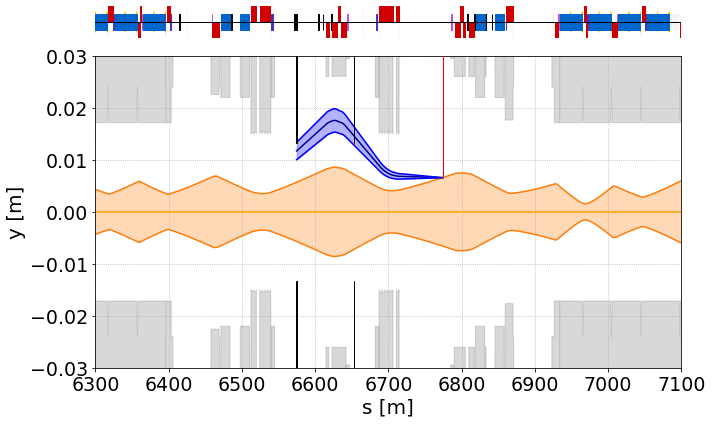

In [19]:

df_chann_part_s = extract_channelled(df_chann_part, start = TCCS_loc, end = TCLA_loc)
df_chann_part_upper_s = extract_channelled(df_chann_part_upper,start = TCCS_loc, end = TCLA_loc)
df_chann_part_lower_s = extract_channelled(df_chann_part_lower, start = TCCS_loc, end = TCLA_loc)

start, stop =  6300 , 7100
fig, ir3_plot = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(10,6), tight_layout=False)
pymadx.Plot._SetMachineAxesStyle(ir3_plot[0])
pymadx.Plot._DrawMachineLattice(ir3_plot[0], layout_data_object)
ir3_plot[0].set_xlim(start,stop)
plot_IR3(ir3_plot[1], df_ref, df_chann_part_s, df_chann_part_upper_s, df_chann_part_lower_s, df_apertures, df_coll, s_start=start, s_stop=stop, fontsize = 20 , fontsize_ticks = 19)



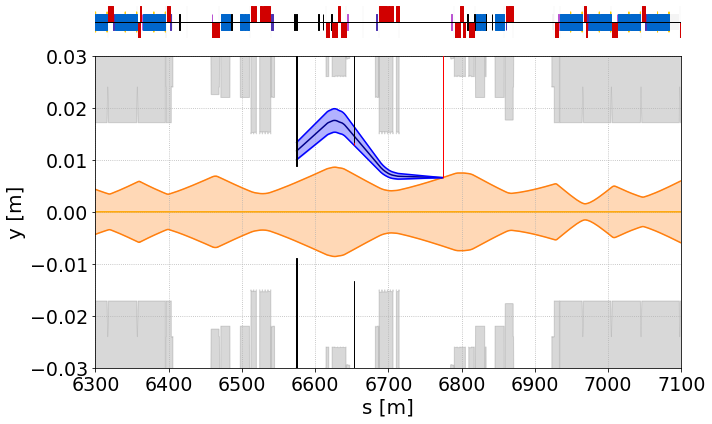

In [25]:

df_chann_part_s = extract_channelled(df_chann_part, start = TCCS_loc, end = TCLA_loc)
df_chann_part_upper_s = extract_channelled(df_chann_part_upper,start = TCCS_loc, end = TCLA_loc)
df_chann_part_lower_s = extract_channelled(df_chann_part_lower, start = TCCS_loc, end = TCLA_loc)

start, stop =  6300 , 7100
fig, ir3_plot = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(10,6), tight_layout=False)
pymadx.Plot._SetMachineAxesStyle(ir3_plot[0])
pymadx.Plot._DrawMachineLattice(ir3_plot[0], layout_data_object)
ir3_plot[0].set_xlim(start,stop)
plot_IR3(ir3_plot[1], df_ref, df_chann_part_s, df_chann_part_upper_s, df_chann_part_lower_s, df_apertures, close_collimator(df_coll, TCLA_name, 8), s_start=start, s_stop=stop, fontsize = 20 , fontsize_ticks = 19)



In [22]:
def merge_df(df1, df2):
    df1 = df1.where(df1['s'] !=0).dropna()
    df2 = df2.where(df2['s'] !=0).dropna()
    return pd.concat([df1, df2]) 

line.track(cry_part_chann, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_stop=TCCS_name)
df_chann_part2 = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0], line.record_last_track.py[0])), columns =['s', 'x', 'y', 'py']), twiss,loc=0, loc_name='ip1')

line.track(cry_part_chann_upper, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_stop=TCCS_name)
df_chann_part_upper2 = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), twiss, loc=0, loc_name='ip1')

line.track(cry_part_chann_lower, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_stop=TCCS_name)
df_chann_part_lower2 = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), twiss, loc=0, loc_name='ip1')

"v_colls = ['tctpv.4r8.b2', 'tcp.d6r7.b2', 'tcsg.d4r7.b2', 'tcspm.d4r7.b2', 'tcla.a6l7.b2', 'tcla.c6l7.b2', 'tctpv.4r5.b2', 'tcla.a5l3.b2', 'tctpv.4r2.b2',  'tctpv.4r1.b2']\nfor coll in v_colls:\n    pos = end_s - line.get_s_position()[line.element_names.index(coll)]\n    ir3_plot[1].text(pos, 0.03, coll, rotation=0, fontsize=15, color='black')"

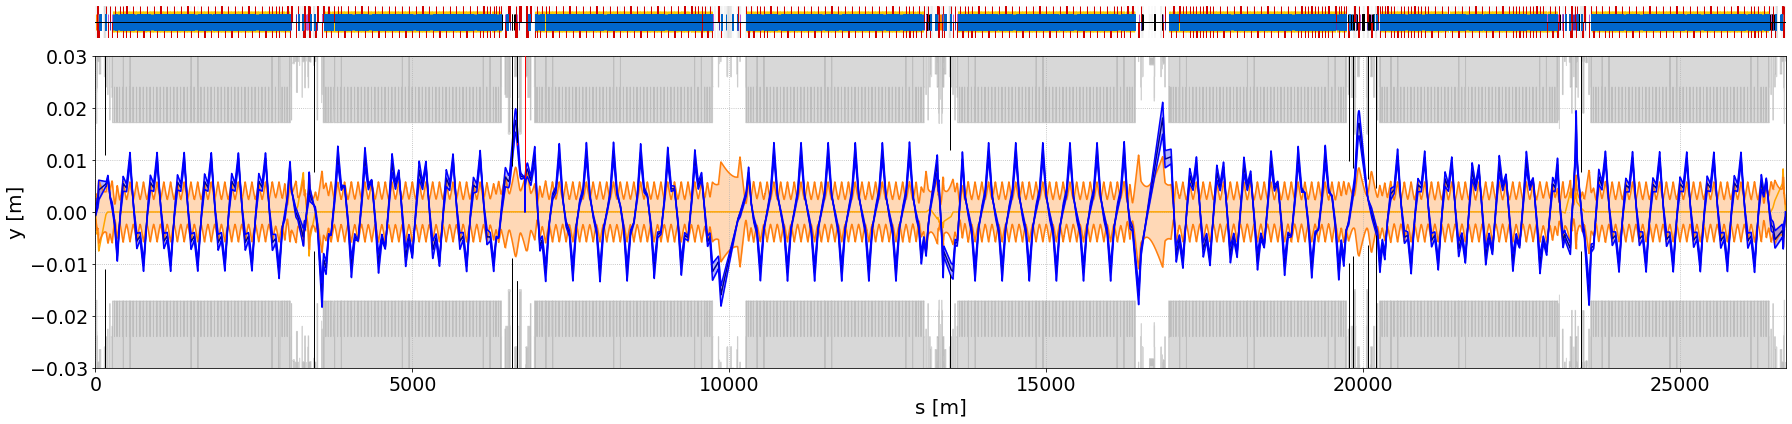

In [23]:
start, stop =  0 , end_s #6300 , 7100
fig, ir3_plot = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(25,6), tight_layout=False)
pymadx.Plot._SetMachineAxesStyle(ir3_plot[0])
pymadx.Plot._DrawMachineLattice(ir3_plot[0], layout_data_object)
ir3_plot[0].set_xlim(start,stop)
#ir3_plot[0].set_title(label='Energy = 1 TeV', y=1.05, fontsize=18)
plot_IR3(ir3_plot[1], df_ref, merge_df(df_chann_part, df_chann_part2), merge_df(df_chann_part_upper, df_chann_part_upper2), merge_df(df_chann_part_lower,df_chann_part_lower2), df_apertures, df_coll, s_start=start, s_stop=stop, fontsize = 20 , fontsize_ticks = 19)
#ir3_plot[1].axvline(9997.005009024102, color='green', alpha = 0.7, linestyle='--')

"""v_colls = ['tctpv.4r8.b2', 'tcp.d6r7.b2', 'tcsg.d4r7.b2', 'tcspm.d4r7.b2', 'tcla.a6l7.b2', 'tcla.c6l7.b2', 'tctpv.4r5.b2', 'tcla.a5l3.b2', 'tctpv.4r2.b2',  'tctpv.4r1.b2']
for coll in v_colls:
    pos = end_s - line.get_s_position()[line.element_names.index(coll)]
    ir3_plot[1].text(pos, 0.03, coll, rotation=0, fontsize=15, color='black')"""

In [23]:
fig.savefig('./Plots/TCCS_first_turn.png', dpi=300, bbox_inches='tight')

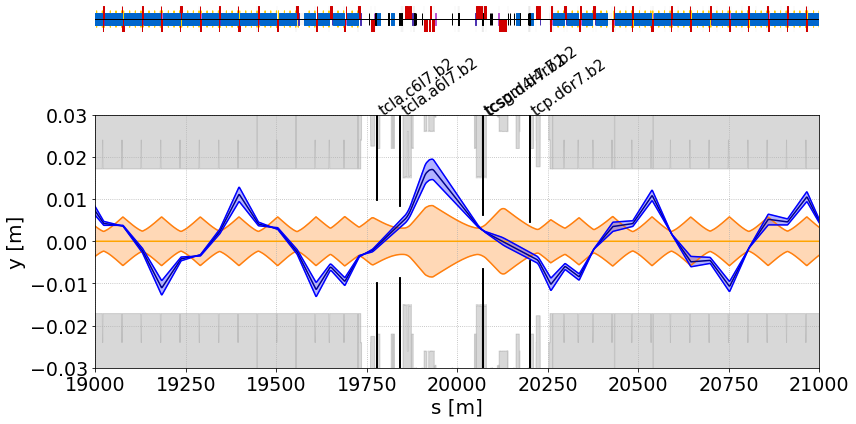

In [33]:
start, stop =  19000, 21000 #6300 , 7100
fig, ir3_plot = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(12,6), tight_layout=False)
pymadx.Plot._SetMachineAxesStyle(ir3_plot[0])
pymadx.Plot._DrawMachineLattice(ir3_plot[0], layout_data_object)
ir3_plot[0].set_xlim(start,stop)
#ir3_plot[0].set_title(label='Energy = 1 TeV', y=1.05, fontsize=18)
plot_IR3(ir3_plot[1], df_ref, merge_df(df_chann_part, df_chann_part2), merge_df(df_chann_part_upper, df_chann_part_upper2), merge_df(df_chann_part_lower,df_chann_part_lower2), df_apertures, df_coll, s_start=start, s_stop=stop, fontsize = 20 , fontsize_ticks = 19)
#ir3_plot[1].axvline(9997.005009024102, color='green', alpha = 0.7, linestyle='--')
v_colls = [ 'tcp.d6r7.b2', 'tcsg.d4r7.b2', 'tcspm.d4r7.b2', 'tcla.a6l7.b2', 'tcla.c6l7.b2']
for coll in v_colls:
    pos = end_s - line.get_s_position()[line.element_names.index(coll)]
    ir3_plot[1].text(pos, 0.03, coll, rotation=35, fontsize=15, color='black')

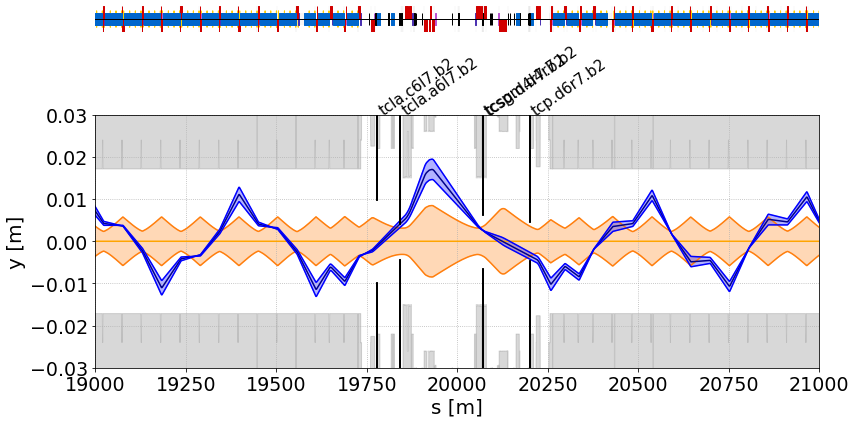

In [39]:
start, stop =  19000, 21000 #6300 , 7100
fig, ir3_plot = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(12,6), tight_layout=False)
pymadx.Plot._SetMachineAxesStyle(ir3_plot[0])
pymadx.Plot._DrawMachineLattice(ir3_plot[0], layout_data_object)
ir3_plot[0].set_xlim(start,stop)
#ir3_plot[0].set_title(label='Energy = 1 TeV', y=1.05, fontsize=18)
plot_IR3(ir3_plot[1], df_ref, merge_df(df_chann_part, df_chann_part2), merge_df(df_chann_part_upper, df_chann_part_upper2), merge_df(df_chann_part_lower,df_chann_part_lower2), df_apertures, close_collimator(df_coll,  'tcla.a6l7.b2', 5), s_start=start, s_stop=stop, fontsize = 20 , fontsize_ticks = 19)
#ir3_plot[1].axvline(9997.005009024102, color='green', alpha = 0.7, linestyle='--')
v_colls = [ 'tcp.d6r7.b2', 'tcsg.d4r7.b2', 'tcspm.d4r7.b2', 'tcla.a6l7.b2', 'tcla.c6l7.b2']
for coll in v_colls:
    pos = end_s - line.get_s_position()[line.element_names.index(coll)]
    ir3_plot[1].text(pos, 0.03, coll, rotation=35, fontsize=15, color='black')

In [40]:
fig.savefig('./Plots/TCCS_first_turn_IR7_closed.png', dpi=300, bbox_inches='tight')

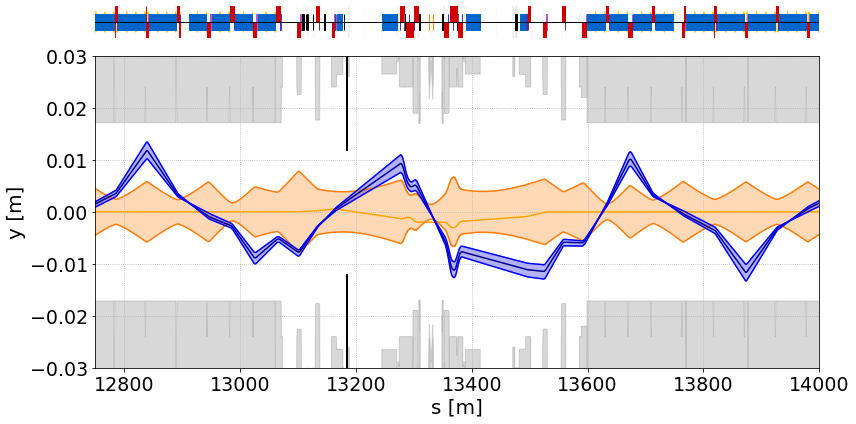

In [26]:
start, stop =  12750, 14000 #6300 , 7100
fig, ir3_plot = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(12,6), tight_layout=False)
pymadx.Plot._SetMachineAxesStyle(ir3_plot[0])
pymadx.Plot._DrawMachineLattice(ir3_plot[0], layout_data_object)
ir3_plot[0].set_xlim(start,stop)
#ir3_plot[0].set_title(label='Energy = 1 TeV', y=1.05, fontsize=18)
plot_IR3(ir3_plot[1], df_ref, merge_df(df_chann_part, df_chann_part2), merge_df(df_chann_part_upper, df_chann_part_upper2), merge_df(df_chann_part_lower,df_chann_part_lower2), df_apertures, df_coll, s_start=start, s_stop=stop, fontsize = 20 , fontsize_ticks = 19)
#ir3_plot[1].axvline(9997.005009024102, color='green', alpha = 0.7, linestyle='--')


In [27]:
fig.savefig('./Plots/TCCS_last_turn_IR5.png', dpi=300, bbox_inches='tight')

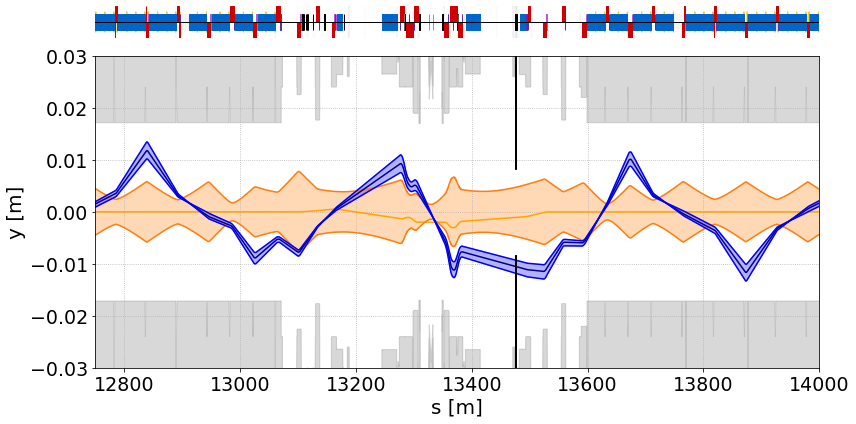

In [31]:
start, stop =  12750, 14000 #6300 , 7100
fig, ir3_plot = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(12,6), tight_layout=False)
pymadx.Plot._SetMachineAxesStyle(ir3_plot[0])
pymadx.Plot._DrawMachineLattice(ir3_plot[0], layout_data_object)
ir3_plot[0].set_xlim(start,stop)
#ir3_plot[0].set_title(label='Energy = 1 TeV', y=1.05, fontsize=18)
plot_IR3(ir3_plot[1], df_ref, merge_df(df_chann_part, df_chann_part2), merge_df(df_chann_part_upper, df_chann_part_upper2), merge_df(df_chann_part_lower,df_chann_part_lower2), df_apertures, close_collimator(df_coll, 'tctpv.4r5.b2', 9 ), s_start=start, s_stop=stop, fontsize = 20 , fontsize_ticks = 19)
#ir3_plot[1].axvline(9997.005009024102, color='green', alpha = 0.7, linestyle='--')

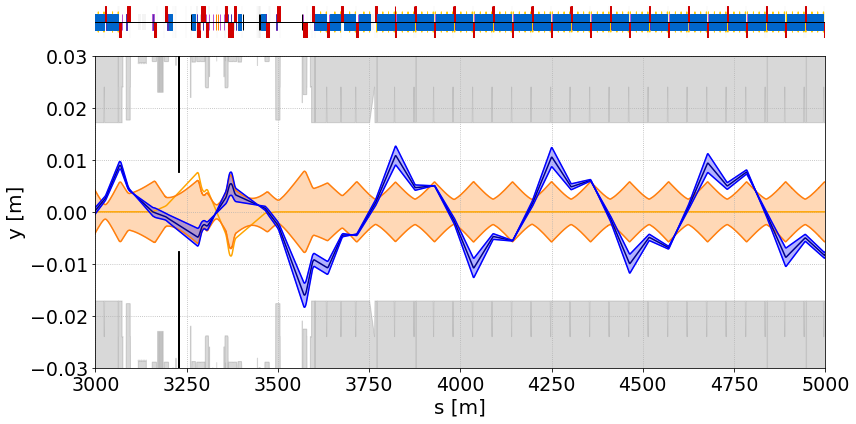

In [24]:
start, stop =  3000, 5000 #6300 , 7100
fig, ir3_plot = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(12,6), tight_layout=False)
pymadx.Plot._SetMachineAxesStyle(ir3_plot[0])
pymadx.Plot._DrawMachineLattice(ir3_plot[0], layout_data_object)
ir3_plot[0].set_xlim(start,stop)
#ir3_plot[0].set_title(label='Energy = 1 TeV', y=1.05, fontsize=18)
plot_IR3(ir3_plot[1], df_ref, merge_df(df_chann_part, df_chann_part2), merge_df(df_chann_part_upper, df_chann_part_upper2), merge_df(df_chann_part_lower,df_chann_part_lower2), df_apertures, close_collimator(df_coll, 'tctpv.4r5.b2', 9 ), s_start=start, s_stop=stop, fontsize = 20 , fontsize_ticks = 19)
#ir3_plot[1].axvline(9997.005009024102, color='green', alpha = 0.7, linestyle='--')

In [32]:
fig.savefig('./Plots/TCCS_last_turn_IR5_closed_TCT.png', dpi=300, bbox_inches='tight')

In [28]:
tw = line.twiss()

In [38]:
end_s - 	3567.150000

23091.73317064787

In [39]:
tw.to_pandas().query("(s<23100.73317064787) & (s>23089.88317064787)")

,name,s,x,px,y,py,zeta,delta,ptau,W_matrix,...,bx_chrom,by_chrom,ax_chrom,ay_chrom,wx_chrom,wy_chrom,ddx,ddpx,ddy,ddpy
85268,mcbcv.6r2.b2_mkex_aper,23090.111958,8.444202e-09,6.574444e-09,5.026496e-07,-8.557271e-09,-0.000004,0.000002,0.000002,"[[5.956833474330582, 0.0, -7.25555055444953e-0...",...,-25.371800,-3.450420,-1.102493,17.643594,25.395743,17.977814,-4.020303,-1.690825,-163.865932,2.762293
85269,mcbcv.6r2.b2_mkex,23090.111958,8.444202e-09,6.574444e-09,5.026496e-07,-8.557271e-09,-0.000004,0.000002,0.000002,"[[5.956833474330582, 0.0, -7.25555055444953e-0...",...,-25.371800,-3.450420,-1.102493,17.643594,25.395743,17.977814,-4.020303,-1.690825,-163.865932,2.762293
85270,drift_26900,23090.111958,8.444202e-09,6.574444e-09,5.026496e-07,-8.557271e-09,-0.000004,0.000002,0.000002,"[[5.956833474330582, 0.0, -7.25555055444953e-0...",...,-25.371800,-3.450420,-1.102493,17.643594,25.395743,17.977814,-4.020303,-1.690825,-163.865932,2.762293
85271,vssb.6r2.a.b2_aper,23090.695303,1.227936e-08,6.574444e-09,4.976578e-07,-8.557271e-09,-0.000004,0.000002,0.000002,"[[5.9876188666567325, -8.881784197001252e-16, ...",...,-25.332715,-3.502192,-1.917123,17.606059,25.405153,17.951007,-5.008868,-1.690825,-162.252525,2.762293
85272,vssb.6r2.a.b2,23090.695303,1.227936e-08,6.574444e-09,4.976578e-07,-8.557271e-09,-0.000004,0.000002,0.000002,"[[5.9876188666567325, -8.881784197001252e-16, ...",...,-25.332715,-3.502192,-1.917123,17.606059,25.405153,17.951007,-5.008868,-1.690825,-162.252525,2.762293
85273,drift_26901,23090.695303,1.227936e-08,6.574444e-09,4.976578e-07,-8.557271e-09,-0.000004,0.000002,0.000002,"[[5.9876188666567325, -8.881784197001252e-16, ...",...,-25.332715,-3.502192,-1.917123,17.606059,25.405153,17.951007,-5.008868,-1.690825,-162.252525,2.762293
85274,vfcdo.b6r2.b.b2_aper,23091.044958,1.457815e-08,6.574444e-09,4.946657e-07,-8.557271e-09,-0.000004,0.000002,0.000002,"[[6.0068329578031765, 4.440892098500626e-16, -...",...,-25.297144,-3.533558,-2.400667,17.583404,25.410798,17.934941,-5.601410,-1.690825,-161.285455,2.762293
85275,vfcdo.b6r2.b.b2,23091.044958,1.457815e-08,6.574444e-09,4.946657e-07,-8.557271e-09,-0.000004,0.000002,0.000002,"[[6.0068329578031765, 4.440892098500626e-16, -...",...,-25.297144,-3.533558,-2.400667,17.583404,25.410798,17.934941,-5.601410,-1.690825,-161.285455,2.762293
85276,drift_26902,23091.044958,1.457815e-08,6.574444e-09,4.946657e-07,-8.557271e-09,-0.000004,0.000002,0.000002,"[[6.0068329578031765, 4.440892098500626e-16, -...",...,-25.297144,-3.533558,-2.400667,17.583404,25.410798,17.934941,-5.601410,-1.690825,-161.285455,2.762293
85277,vmabd.6r2.b.b2_aper,23091.064958,1.470964e-08,6.574444e-09,4.944945e-07,-8.557271e-09,-0.000004,0.000002,0.000002,"[[6.007949096439048, 4.440892098500626e-16, -7...",...,-25.294839,-3.535360,-2.428212,17.582104,25.411121,17.934022,-5.635303,-1.690825,-161.230139,2.762293


## zoom

In [36]:
# PLOT 

def plot_IR3_ZOOM(plot_axis, df_ref, df_chann, df_chann_upper, df_chann_lower, df_apertures, df_coll=None, s_start=6650, s_stop= 6850, df_TCCP= None, fontsize = 17, fontsize_ticks = 15):
    
    plot_axis.plot(df_ref["s"],df_ref["y"],color="orange")


    plot_axis.plot(df_ref["s"],df_ref["5_sigma_y"], color='C1')
    plot_axis.plot(df_ref["s"],-df_ref["5_sigma_y"], color='C1')
    plot_axis.fill_between(df_ref["s"], df_ref["5_sigma_y"], -df_ref["5_sigma_y"], color='C1', alpha=0.3)


    plot_axis.plot(df_chann["s"],df_chann["y"], color='darkblue')
    plot_axis.plot(df_chann_upper["s"],df_chann_upper["y"], color='blue')
    plot_axis.plot(df_chann_lower["s"],df_chann_lower["y"], color='blue')
    plot_axis.fill_between(df_chann["s"], df_chann_upper["y"],df_chann_lower["y"], color='blue', alpha=0.3)


    plot_axis.set_xlabel('s [m]',  fontsize=fontsize)
    plot_axis.set_xlim(s_start, s_stop)
    plot_axis.set_ylim(-0.03, 0.03)
    plot_axis.set_ylabel('y [m]',  fontsize=fontsize)
    plot_axis.grid(linestyle=':')
    plot_axis.tick_params(axis='both', which='major', labelsize=fontsize_ticks)


    if df_TCCP is not None:
        plot_axis.plot(df_TCCP["s"],df_TCCP["y"], color='darkblue')
    
    
    plot_axis.tick_params(axis='both', which='major', labelsize=15)
    
    #plot_axis.text(end_s - TCCS_loc, max(plot_axis.get_yticks())+0.0008, "TCCS", horizontalalignment='center', fontsize=17)
    #plot_axis.text(end_s - TCCP_loc, max(plot_axis.get_yticks())+0.0008, "TCCP", horizontalalignment='center', fontsize=17)

    # convert, xcp function handles dataframe in m
    xcp.plot_apertures(df_apertures[['xmin', 'xmax', 'ymin', 'ymax']].apply(lambda x: convert_mm_to_m(x)), plot_axis, "v")
    
    if df_coll is not None:
        plot_collimators(df_coll, plot_axis, "v", df_ref, df_chann_lower, plot_offplane_coll = False)

In [33]:
if rpx:
    df_TCCP_chann=df_TCCP_chann[df_TCCP_chann['y']>1e-3]

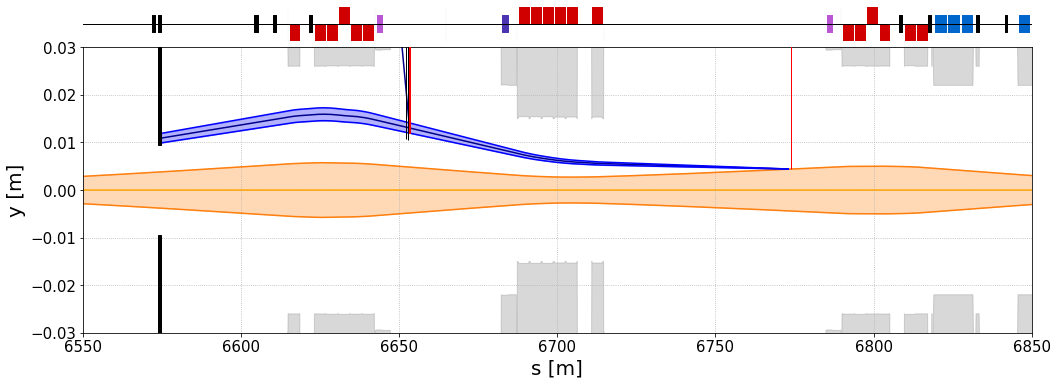

In [40]:
#start, stop =  6640 , 6660
fig, ir3_plot = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.12, 1]}, sharex=True, figsize=(17,6))
pymadx.Plot._SetMachineAxesStyle(ir3_plot[0])
pymadx.Plot._DrawMachineLattice(ir3_plot[0], layout_data_object)
plt.subplots_adjust(wspace=2, hspace=0.04)
ir3_plot[0].set_xlim(start,stop)
# ir3_plot[0].set_title(label='Energy = 1 TeV', y=1.05, fontsize=18)
plot_IR3_ZOOM(ir3_plot[1], df_ref, df_chann_part, df_chann_part_upper, df_chann_part_lower, df_apertures, df_coll, 6550, 6850, df_TCCP_chann,20,19 )

In [41]:
fig.savefig('./Plots/IR3_large_new_dc.png', dpi=400, bbox_inches='tight')

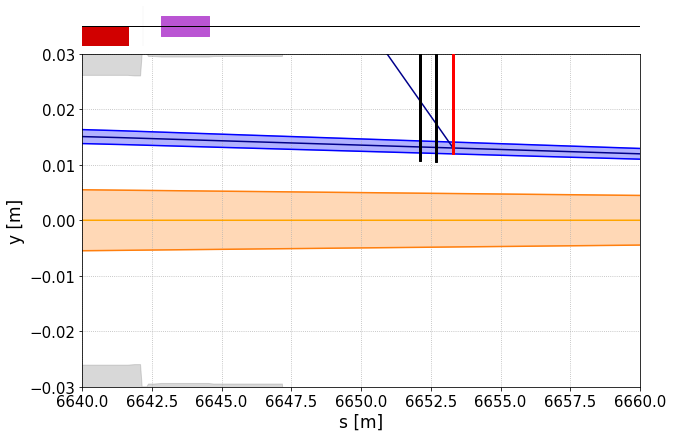

In [116]:
start, stop =  6640 , 6660
fig, ir3_plot = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.12, 1]}, sharex=True, figsize=(10,7))
plt.subplots_adjust(wspace=2, hspace=0.04)
pymadx.Plot._SetMachineAxesStyle(ir3_plot[0])
pymadx.Plot._DrawMachineLattice(ir3_plot[0], layout_data_object)
ir3_plot[0].set_xlim(start,stop)
# ir3_plot[0].set_title(label='Energy = 1 TeV', y=1.05, fontsize=18)
plot_IR3_ZOOM(ir3_plot[1], df_ref, df_chann_part, df_chann_part_upper, df_chann_part_lower, df_apertures, df_coll, start, stop, df_TCCP_chann) 

In [117]:
#fig.savefig('./Plots/IR3_very_zoomed.png', dpi=400, bbox_inches='tight')

In [60]:
def calc_nsigma_TCCP(df_twiss, df_chann, emittance_phy):

    s_centre = float(df_twiss[df_twiss["name"] == TCCP_name]['s'])
    hgap =  df_chann[df_chann['s'] == s_centre]['y'].iloc[0]  - df_twiss[df_twiss['s'] == s_centre]['y'].iloc[0]
    beta_y = float(df_twiss[df_twiss["name"] == TCCP_name]['bety'])
    sigma =  np.sqrt(emittance_phy*beta_y)

    #five_sig_gap  = df_twiss[df_twiss['s'] == s_centre]['5_sigma_y'].iloc[0] - df_twiss[df_twiss['s'] == s_centre]['y'].iloc[0]
    #print('check: ', five_sig_gap/sigma)
    
    return hgap/sigma

In [61]:
print('Sigma CRY2 at 6.8 TeV = ',  calc_nsigma_TCCP(df_ref, df_chann_part, emittance_phy))

Sigma CRY2 at 6.8 TeV =  30.047083877560752
